<a href="https://colab.research.google.com/github/PCBZ/CS6140/blob/main/HW2B/HW2B_Problem5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading wine dataset ...
Training the model...
Train Accuracy: 100.00%
Test Accuracy: 100.00%
Training Time: 0.04 seconds


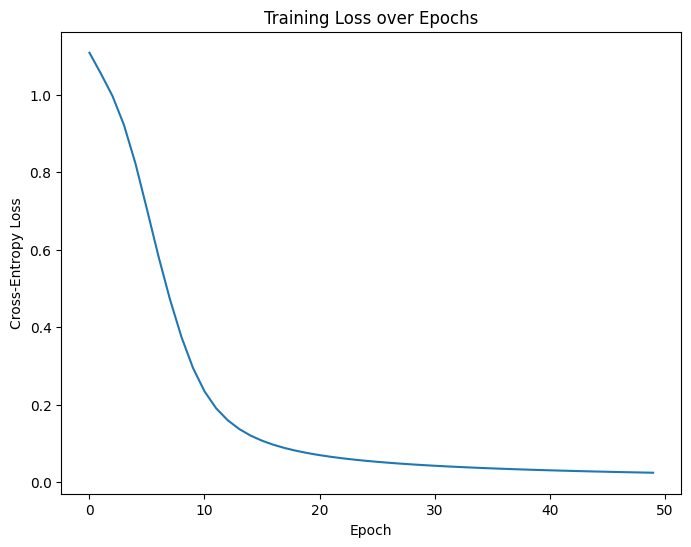

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

class MultiClassNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 0.1):
        """
        Initialize the neural network
        :param input_size: Number of input features
        :param hidden_size: Number of neurons in the hidden layer
        :param output_size: Number of output classes
        :param learning_rate: Learning rate for gradient descent
        """
        self.weights1 = np.random.randn(input_size, hidden_size) * 0.1
        self.bias1 = np.zeros((1, hidden_size))
        self.weights2 = np.random.randn(hidden_size, output_size) * 0.1
        self.bias2 = np.zeros((1, output_size))

        self.learning_rate = learning_rate

    def relu(self, z):
        """
        Rectified Linear Unit activation function
        :param x: Input to the activation function
        :return: Output of the activation function
        """
        return np.maximum(0, z)

    def relu_derivative(self, z):
        """
        Derivative of the Rectified Linear Unit activation function
        :param x: Input to the activation function
        :return: Derivative of the activation function
        """
        return (z > 0).astype(float)

    def softmax(self, z):
        """
        Softmax activation function
        :param z: Input to the activation function
        :return: Output of the activation function
        """
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        """
        Cross-entropy loss function
        :param y_true: True labels
        :param y_pred: Predicted labels
        :return: Loss value
        """
        n = y_true.shape[0]
        epsilon = 1e-15
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / n
        return loss

    def forward_pass(self, X):
        """
        Perform a forward pass through the neural network
        :param X: Input data
        :return: Output of the neural network
        """
        # Input -> hidden
        self.hidden_inputs = X @ self.weights1 + self.bias1
        self.hidden_outputs = self.relu(self.hidden_inputs)

        # Hidden -> output
        self.output_inputs = self.hidden_outputs @ self.weights2 + self.bias2
        self.output_outputs = self.softmax(self.output_inputs)

        return self.output_outputs

    def backward_pass(self, X, y):
        """
        Perform a backward pass through the neural network to compute gradients
        :param X: Input data
        :param y: True labels
        :return: Gradients of the weights and biases
        """
        n = X.shape[0]

        # Output layer gradient
        d_output = (self.output_outputs - y) / n
        d_weights2 = self.hidden_outputs.T @ d_output
        d_bias2 = np.sum(d_output, axis=0, keepdims=True)

        # Hidden layer gradient
        d_hidden = d_output @ self.weights2.T * self.relu_derivative(self.hidden_inputs)
        d_weights1 = X.T @ d_hidden
        d_bias1 = np.sum(d_hidden, axis=0, keepdims=True)

        return d_weights1, d_bias1, d_weights2, d_bias2

    def update_weights(self, gradients):
        """
        Update the weights and biases of the neural network
        :param gradients: Gradients of the weights and biases
        """
        d_weights1, d_bias1, d_weights2, d_bias2 = gradients

        self.weights1 -= self.learning_rate * d_weights1
        self.bias1 -= self.learning_rate * d_bias1
        self.weights2 -= self.learning_rate * d_weights2
        self.bias2 -= self.learning_rate * d_bias2

    def predict(self, X):
        """
        Make predictions using the trained neural network
        :param X: Input data
        :return: Predicted labels
        """
        output = self.forward_pass(X)
        return np.argmax(output, axis=1)

    def train(self, X, y, epochs = 1000):
        """
        Train the neural network
        :param X: Input data
        :param y: True labels
        :param epochs: Number of training epochs
        """

        y_one_hot = self.one_hot_encode(y)
        loss_history = []

        time_start = time.time()

        for epoch in range(epochs):
            # Forward pass
            output = self.forward_pass(X)

            # Calculate
            loss = self.cross_entropy_loss(y_one_hot, output)
            loss_history.append(loss)

            # Backward pass
            gradients = self.backward_pass(X, y_one_hot)
            self.update_weights(gradients)

        time_end = time.time()
        self.training_time = time_end - time_start

        return loss_history

    def one_hot_encode(self, y):
        """
        One-hot encode the labels
        :param y: True labels
        :return: One-hot encoded labels
        """
        num_classes = len(np.unique(y))
        one_hot_y = np.zeros((y.shape[0], num_classes))
        one_hot_y[np.arange(y.shape[0]), y] = 1
        return one_hot_y

def load_wine_data():
    train_url = "https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/data/train_wine.csv"
    test_url = "https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/data/test_wine.csv"

    # Load data
    train_data = pd.read_csv(train_url, header=None)
    test_data = pd.read_csv(test_url, header=None)

    # Separate features and labels
    X_train = train_data.iloc[:, 1:].values  # Features are columns 1-13
    y_train = train_data.iloc[:, 0].values   # Labels are column 0

    X_test = test_data.iloc[:, 1:].values
    y_test = test_data.iloc[:, 0].values

    unique_labels = np.unique(y_train)

    if unique_labels.min() > 0:
        y_train = y_train - 1
        y_test = y_test - 1

    return X_train, y_train, X_test, y_test


def main():
    # Load data
    print("Loading wine dataset ...")
    X_train, y_train, X_test, y_test = load_wine_data()

    # Normalize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Set hyperparameters
    input_size = X_train.shape[1]
    hidden_size = 10
    output_size = len(np.unique(y_train))

    model = MultiClassNN(input_size, hidden_size, output_size, learning_rate = 0.5)

    # Train the model
    print("Training the model...")
    loss_history = model.train(X_train, y_train, epochs = 50)

    # Evaluation
    train_accuracy = np.mean(model.predict(X_train) == y_train)
    test_accuracy = np.mean(model.predict(X_test) == y_test)
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Training Time: {model.training_time:.2f} seconds")

    # Plot training loss
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history)
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.show()


if __name__ == "__main__":
    main()
